<a href="https://colab.research.google.com/github/Kidara/Bioinformatics-Project/blob/main/Bioinformatics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install -q "cache_decorator[all]"==2.0.8 humanize scikit-learn
!pip install -q barplots plot_keras_history epigenomic_dataset>=1.1.7
!pip install -q ucsc_genomes_downloader>=1.1.22 keras_bed_sequence>=1.1.5
!pip install -q keras_mixed_sequence ray seaborn minepy boruta prince cmake
#!pip install -q multicoretsne silence_tensorflow>=1.1.1
!pip install tsnecuda==3.0.0+cu110 -f https://tsnecuda.isx.ai/tsnecuda_stable.html --no-dependencies
!pip install -q faiss tbb

Looking in links: https://tsnecuda.isx.ai/tsnecuda_stable.html


In [ ]:
#@markdown Imports

from tqdm.auto import tqdm # A simple loading bar
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt # A standard plotting library
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
import pandas as pd
import numpy as np
from multiprocessing import cpu_count
from glob import glob 
import seaborn as sns
from barplots import barplots

from typing import Dict, List, Tuple, Optional
from cache_decorator import Cache
from epigenomic_dataset import load_epigenomes
from epigenomic_dataset import active_promoters_vs_inactive_promoters
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers
from epigenomic_dataset.utils import normalize_epigenomic_data
from ucsc_genomes_downloader import Genome
from keras_bed_sequence import BedSequence
from keras_mixed_sequence import MixedSequence, VectorSequence

from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr, entropy, wilcoxon
from minepy import MINE

from typing import Tuple
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer, PReLU
from tensorflow.keras.layers import Conv1D, AveragePooling1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.callbacks import EarlyStopping, Callback
#from extra_keras_metrics import get_complete_binary_metrics

import gc
import tsnecuda
from tsnecuda import TSNE
import multiprocessing
from multiprocessing import Process, Queue

# Epigenomic data exploratory analysis

In the following analysis we use a fixed window size of 256 base pairs. However, in the final model evaluation, all available preprocessed windows sizes will be used.

## Epigenomic data retrieval

In order to retrieve epigenomic data of promoters and enhancers regions, we use the [epigenomic_dataset](https://github.com/AnacletoLAB/epigenomic_dataset) python package that already preprocessed the data with fixed window sizes. The cell line considered is "HEK293", and the assembly genome is "hg38". Two metrics are examined, used to aggregate values coming from the window around the epigenomic regions. In particular, 'mean' metric aggregates values calculating the mean value in the window considered; while the 'max' metric aggregates values calculating the max value in the window considered. In general, 'mean' metric is more reliable, since values in the epigenomic data are usually noisy.

In [ ]:
window_size = 256
cell_line="HEK293"
assembly = "hg38"

In [ ]:
# Retrieve epigenomic data using both mean and max metric

epigenomes = {"mean":{}, "max":{}}
labels = {"mean":{}, "max":{}}

for metric,_ in epigenomes.items():
    epigenomes[metric]["promoters"], labels[metric]["promoters"] =\
        active_promoters_vs_inactive_promoters(
            cell_line = cell_line,
            assembly = assembly,
            dataset = "fantom",
            metric = metric,
            window_size = window_size,
            root = "datasets",
            #binarize = True,
            #min_active_tpm_value = 1,
            #max_inactive_tpm_value = 0,
        )

    epigenomes[metric]["enhancers"], labels[metric]["enhancers"] =\
        active_enhancers_vs_inactive_enhancers(
            cell_line = cell_line,
            assembly = assembly,
            dataset = "fantom",
            metric = metric,
            window_size = window_size,
            root = "datasets",
            #binarize = True,
            #min_active_tpm_value = 0.1,
            #max_inactive_tpm_value = 0,
        )

In [ ]:
for region in ("promoters","enhancers"):
    samples, features = epigenomes["mean"][region].shape
    print(f"There are {samples} samples and {features} features for {region} regions.")

There are 99881 samples and 196 features for promoters regions.
There are 63285 samples and 196 features for enhancers regions.


## NaN values imputation

NaN values are a problem from a theoretical and practical point-of-view. From a theoretical standpoint, we don't know how to interpret them, and practically speaking NaN values corrupts every subsequent calculation done on them. Hence, we need to decide how to treat them.

In [ ]:
for metric,_ in epigenomes.items():
    print(f"[{metric} metric]")
    nan_promoters_epigenomes = epigenomes[metric]["promoters"].isna().sum().sum()
    nan_promoters_labels = labels[metric]["promoters"].isna().sum().sum()
    nan_enhancers_epigenomes = epigenomes[metric]["enhancers"].isna().sum().sum()
    nan_enhancers_labels = labels[metric]["enhancers"].isna().sum().sum()

    print(f"NaN values in promoters epigenomes: {nan_promoters_epigenomes}")
    print(f"NaN values in promoters labels: {nan_promoters_labels}")
    print(f"NaN values in enhancers epigenomes: {nan_enhancers_epigenomes}")
    print(f"NaN values in enhancers labels: {nan_enhancers_labels}")

[mean metric]
NaN values in promoters epigenomes: 0
NaN values in promoters labels: 0
NaN values in enhancers epigenomes: 1
NaN values in enhancers labels: 0
[max metric]
NaN values in promoters epigenomes: 0
NaN values in promoters labels: 0
NaN values in enhancers epigenomes: 1
NaN values in enhancers labels: 0


Since we are dealing with a supervised task, if we find NaN values in labels we have to drop that rows. Luckily for us, we have no NaN values in labels.

However we need to sanitize the NaN values in epigenomic data: we can choose to drop entire rows or columns (if the number of NaN values is high for such row/column) or impute missing values. Since there is only 1 missing value, we proceed to impute it using a KNN Imputer.

In [ ]:
#@markdown KNN imputation function
def knn_imputation(df:pd.DataFrame, neighbours:int=15, weights:str='distance')->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=15,
        The number of neighbours to consider.
    weights:int='distance'
        How the neighbour points are weightened
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours, weights=weights).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [ ]:
for metric,_ in epigenomes.items():
    epigenomes[metric]["enhancers"] = knn_imputation(epigenomes[metric]["enhancers"])

In [ ]:
for metric,_ in epigenomes.items():
    nan_promoters_epigenomes = epigenomes[metric]["promoters"].isna().sum().sum()
    nan_promoters_labels = labels[metric]["promoters"].isna().sum().sum()
    nan_enhancers_epigenomes = epigenomes[metric]["enhancers"].isna().sum().sum()
    nan_enhancers_labels = labels[metric]["enhancers"].isna().sum().sum()

    assert(nan_promoters_epigenomes==0)
    assert(nan_promoters_labels==0)
    assert(nan_enhancers_epigenomes==0)
    assert(nan_enhancers_labels==0)

## Mean and max metrics comparison

We now check if there are differences in feature values using 'mean' or 'max' metric, to understand if it is useful to use features from both metrics.

In [ ]:
print("[Features with MSE=0 are not displayed]")
features_to_check = set()
for region in ("promoters","enhancers"):
    for column in epigenomes["mean"][region].columns:
        mse = mean_squared_error(
            epigenomes["mean"][region][column],
            epigenomes["max"][region][column])
        if mse > 0:
            print(f"MSE for feature {column} in {region} between mean and max metric: {mse}")
            features_to_check.add(column)

[Features with MSE=0 are not displayed]
MSE for feature CTCF in promoters between mean and max metric: 33.60133364904235
MSE for feature CTCF in enhancers between mean and max metric: 12.711559288931026
MSE for feature ZNF610 in enhancers between mean and max metric: 4.706457535357183e-10


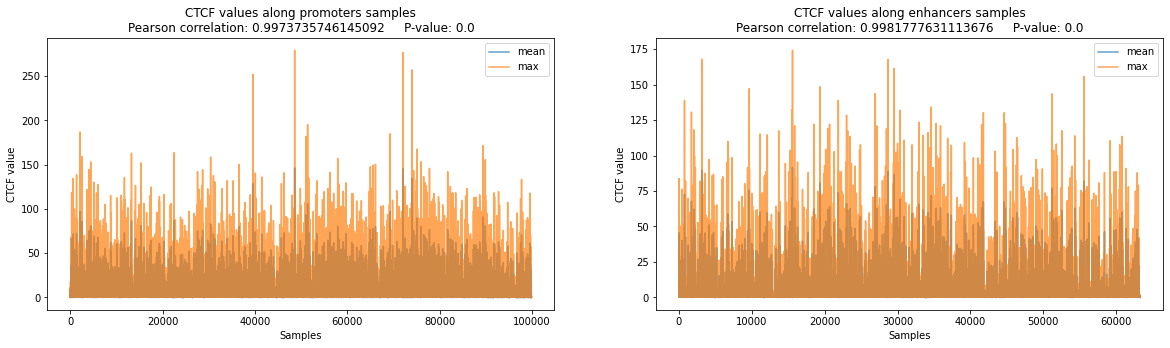

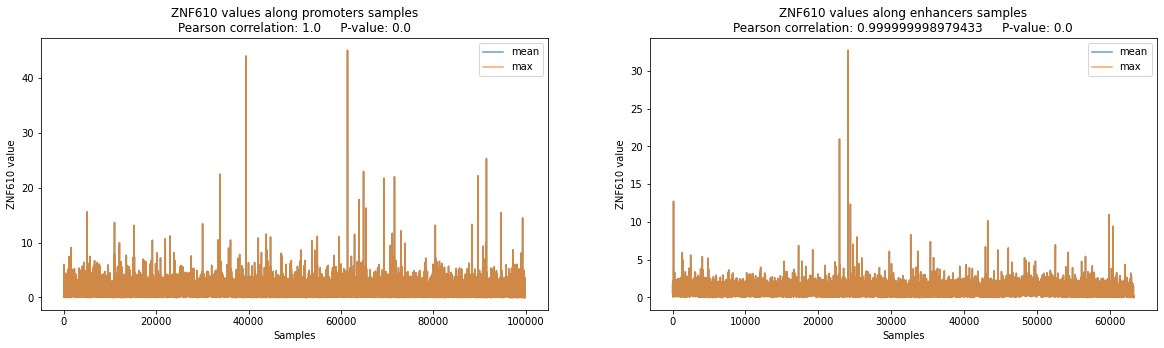

In [ ]:
for feature in features_to_check:
    plt.figure(figsize=(20,5))
    for i, region in enumerate(("promoters","enhancers")):
        plt.subplot(1,2,i+1)
        features_mean = epigenomes["mean"][region][feature].to_numpy()
        features_max = epigenomes["max"][region][feature].to_numpy()
        corr, p_value = pearsonr(features_mean,features_max)
        plt.plot(features_mean, alpha=0.7)
        plt.plot(features_max, alpha=0.7)
        plt.legend(["mean", "max"])
        plt.xlabel("Samples")
        plt.ylabel(f"{feature} value")
        plt.title(f"{feature} values along {region} samples\nPearson correlation: {corr}     P-value: {p_value}")

    plt.show()

We can see that only 1 feature (out of 196), namely 'CTCF', varies consistently in both regions using the two different metrics. But even this feature is extremely correlated between 'mean' and 'max' metrics. Hence, we decide to keep features coming from the 'mean' metric only.

In [ ]:
# Change dict structure to lighten the notation
for metric in ("mean","max"):
    for region in ("promoters","enhancers"):
        epigenomes[region] = epigenomes[metric][region]
        labels[region] = labels[metric][region]
    del epigenomes[metric]
    del labels[metric]

## Samples-over-features ratio

We now check if the samples-over-features ratio is greater than 1.

This is necessary because if the number of features is greater than the number of samples, we have a high probability of finding a feature that correctly classify (or accurately fit, in case of regression) our data just by chance.

In [ ]:
for region, x in epigenomes.items():
    print(
        f"The samples-over-features ratio for {region} data is: {x.shape[0]/x.shape[1]}"
    )
    print("="*80)

The samples-over-features ratio for promoters data is: 509.5969387755102
The samples-over-features ratio for enhancers data is: 322.8826530612245


The samples-over-features ratio is nice and it's time to assess class balance.

## Class balance / Labels distribution

Strong imbalance in datasets can constitute a problem in the learning phase. If the ratio between positive and negative examples is too low (or high), many classifiers will end to predict the most common class, forgetting the less common one (which is often the one we are interested in).

Since in this work we are interested in a regression task, we don't have explicit classes in the labels. Nevertheless, we can visualize the distribution of the labels.

In [ ]:
#Classification
#print("Positive enhancers labels = {}".format(labels["enhancers"].sum().sum()))
#print("Positive-over-negative enhancers labels = {}".format(labels["enhancers"].sum().sum()/labels["enhancers"].count().sum()))

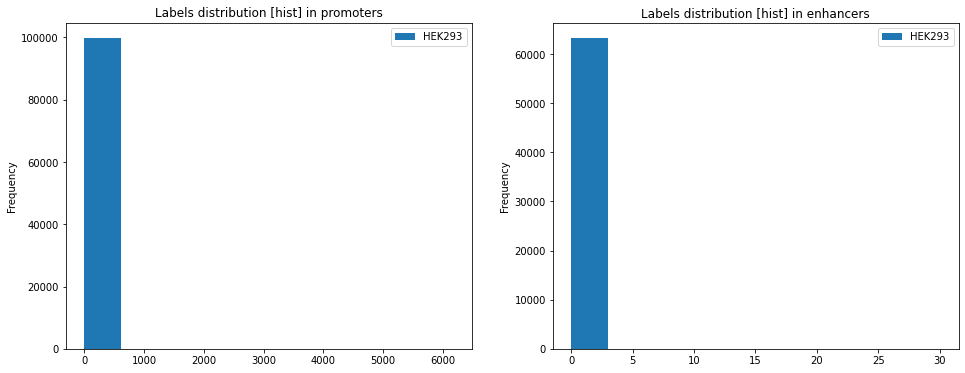

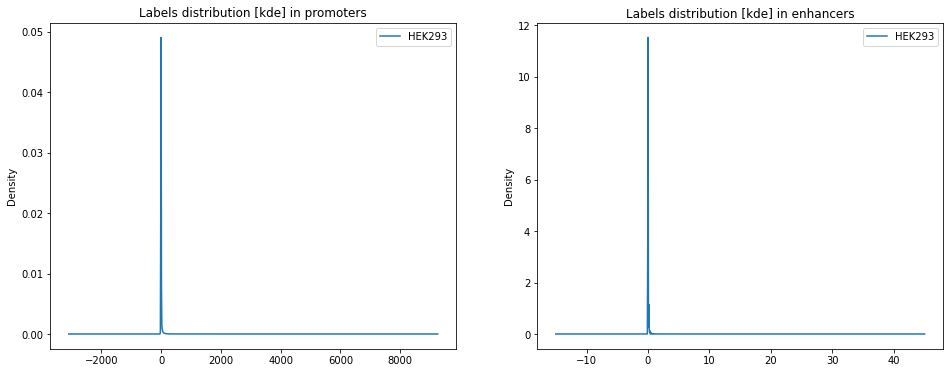

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

for axis, (region, y) in zip(axes.ravel(), labels.items()):
    y.plot(kind='hist', ax=axis)
    axis.set_title(f"Labels distribution [hist] in {region}")
fig.show()


fig, axes = plt.subplots(ncols=2, figsize=(16,6))

for axis, (region, y) in zip(axes.ravel(), labels.items()):
    y.plot(kind='kde', ax=axis)
    axis.set_title(f"Labels distribution [kde] in {region}")
fig.show()

Some outliers seem to compromise the readability of the distribution, we may consider to discard them, or simply to clip all labels to a max value.

### Labels clipping

We want to find an optimal clip value for each region.

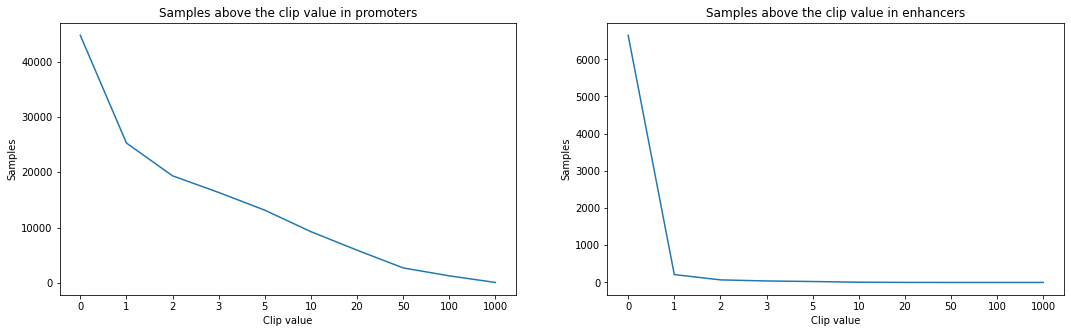

In [ ]:
plt.figure(figsize=(18,5))
for i, (region, y) in enumerate(labels.items()):
    aggregated = []
    clip_values = [0,1,2,3,5,10,20,50,100,1000]
    for clip_value in clip_values:
        aggregated.append(sum([y>clip_value]).sum())
    plt.subplot(1,2,i+1)
    plt.plot(aggregated)
    plt.xticks(range(10), clip_values)
    plt.xlabel("Clip value")
    plt.ylabel("Samples")
    plt.title(f"Samples above the clip value in {region}")
plt.show()

We decide to select a clip value of 50 for promoters and of 1 for enhancers.

In [ ]:
labels["promoters"][labels["promoters"]>50] = 50
labels["enhancers"][labels["enhancers"]>1] = 1

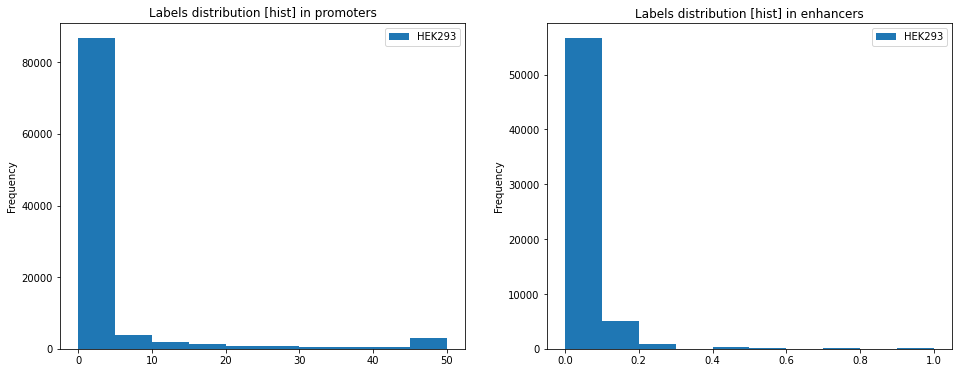

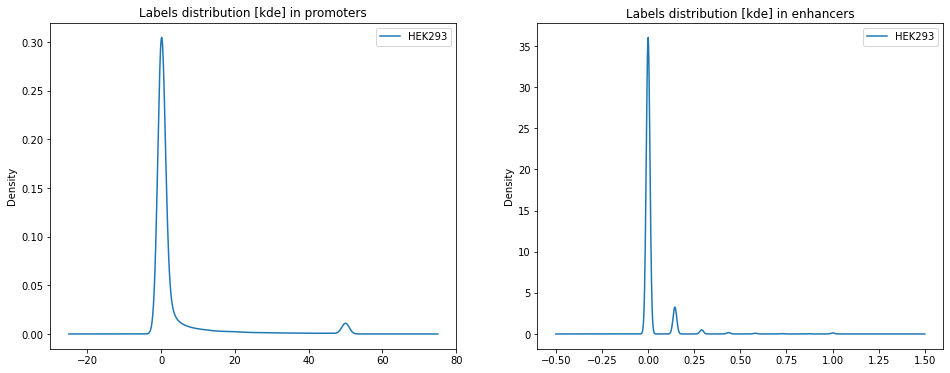

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))

for axis, (region, y) in zip(axes.ravel(), labels.items()):
    y.plot(kind='hist', ax=axis)
    axis.set_title(f"Labels distribution [hist] in {region}")
fig.show()


fig, axes = plt.subplots(ncols=2, figsize=(16,6))

for axis, (region, y) in zip(axes.ravel(), labels.items()):
    y.plot(kind='kde', ax=axis)
    axis.set_title(f"Labels distribution [kde] in {region}")
fig.show()

## Robust scaling

At this point we want features that are comparable in their range of values. This is done because features with very different ranges of values makes learning much more difficult. In linear classifiers, for example, if a feature assumes high values, its importance is bigger in the prediction with respect to another feature with lower values. We want to avoid this and other common problems with unscaled features.

In order to do so, a Robust Scaler is used. As the name suggest, such scaler is robust to outliers, using quartiles to do its calculations.

In [ ]:
#@markdown Robust Z-scoring function
def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [ ]:
epigenomes["promoters"] = robust_zscoring(epigenomes["promoters"])
epigenomes["enhancers"] = robust_zscoring(epigenomes["enhancers"])

## Feature selection

In this section we want to illustrate some methods to analyze and possibly discard useless features for the task considered.

### Drop constant features

We want to check if there are constant features. These features have no predictive power and we want to discard them.

In [ ]:
#@markdown Drop constant features function
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [ ]:
const_features_promoters = drop_constant_features(epigenomes["promoters"]).shape != epigenomes["promoters"].shape
const_features_enhancers = drop_constant_features(epigenomes["enhancers"]).shape != epigenomes["enhancers"].shape
if const_features_promoters:
    print("There are constant features in promoters epigenomic data")
else:
    print("There are no constant features in promoters epigenomic data")
if const_features_enhancers:
    print("There are constant features in enhancers epigenomic data")
else:
    print("There are no constant features in enhancers epigenomic data")

There are no constant features in promoters epigenomic data
There are no constant features in enhancers epigenomic data


### Correlation with output

We want to check if there are features uncorrelated with the output. If this is the case, we want to check if those features convey some information with respect to the output, using the Maximal Information-based Nonparametric Exploration (MINE). If we find out that those features don't convey any useful information for the task we are interested in, we may consider to discard them.

In any case, this analysis should be done using the proper training set generated in the holdout split during the final model evaluation function.

In [ ]:
#@markdown Correlation with output function
def correlation_with_output(
    epigenomes:Dict,
    labels:Dict,
    p_value_threshold:float=0.05,
    correlation_threshold:float=0.01
)->Dict:
    """Return a dictionary of sets of uncorrelated features with the output of each region.
    
    Parameters
    --------------------
    epigenomes:Dict,
        The epigenomic data to analyze (subdivided in regions).
    labels:Dict,
        The labels to consider (subdivided in regions).
    p_value_threshold:float=0.05,
        The p-value threshold over which the features are considered not correlated
        with the output in a statistically significant manner.
    correlation_threshold:float=0.01,
        The threshold compared with the MINE correlation, under which the features are
        definitively considered not correlated with the ouput.
        
    Returns
    --------------------
    The dictionary of sets of uncorrelated features.
    """
    uncorrelated = {
        region: set()
        for region in epigenomes
    }

    for region, x in epigenomes.items():
        for column in tqdm(x.columns, desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=True):
            correlation, p_value = pearsonr(x[column].values.ravel(), labels[region].values.ravel())
            if p_value > p_value_threshold:
                print(region, column, correlation, "pvalue", p_value)
                uncorrelated[region].add(column)

    for region, x in epigenomes.items():
        for column in tqdm(x.columns, desc=f"Running Spearman test for {region}", dynamic_ncols=True, leave=True):
            correlation, p_value = spearmanr(x[column].values.ravel(), labels[region].values.ravel())
            if p_value > p_value_threshold:
                print(region, column, correlation)
                uncorrelated[region].add(column)

    for region, x in epigenomes.items():
        for column in tqdm(uncorrelated[region].copy(), desc=f"Running MINE test for {region}", dynamic_ncols=True, leave=True):
            mine = MINE()
            mine.compute_score(x[column].values.ravel(), labels[region].values.ravel())
            score = mine.mic()
            if score < correlation_threshold:
                print(region, column, score)
            else:
                uncorrelated[region].remove(column)

    return uncorrelated

In [ ]:
uncorrelated = correlation_with_output(epigenomes, labels)

Running Pearson test for promoters:   0%|          | 0/196 [00:00<?, ?it/s]

promoters AEBP2 -0.0019535291436963073 pvalue 0.5369805875382249
promoters ZNF596 0.0056886045957130335 pvalue 0.07220615402238882
promoters ZNF16 0.0008404625633280189 pvalue 0.7905348565643735


Running Pearson test for enhancers:   0%|          | 0/196 [00:00<?, ?it/s]

enhancers RBAK 0.004470210359997206 pvalue 0.260787264805361
enhancers ZNF354C 0.004225295480091937 pvalue 0.2878179453217342
enhancers ZNF680 0.003894396009481489 pvalue 0.32724484774645685
enhancers ZNF548 -0.0016492172927282719 pvalue 0.6782315071374408
enhancers ZNF768 -0.0035644507135120045 pvalue 0.36989154250855427
enhancers ZNF626 0.007294135660277597 pvalue 0.06651485621152109
enhancers BCL6B -0.001263928221224492 pvalue 0.7505197717220725
enhancers ZNF791 -0.0033395859440312195 pvalue 0.4008472613306334
enhancers ZNF529 0.004114655703092209 pvalue 0.3006279502418832
enhancers ZNF157 0.002778056970144905 pvalue 0.4846459484646479
enhancers ZNF624 0.0032121021003954833 pvalue 0.41906818175051147
enhancers ZNF404 -0.007038975374545218 pvalue 0.07660269835743876
enhancers ZNF701 0.004639215975808798 pvalue 0.2431909604707223
enhancers ZNF19 -0.0074225334340106254 pvalue 0.06186819041532239
enhancers ZNF169 -0.00748026895307323 pvalue 0.059868097149682546
enhancers ZNF266 0.003352

Running Spearman test for promoters:   0%|          | 0/196 [00:00<?, ?it/s]

promoters AEBP2 0.001685142081377486
promoters ZNF585B -0.005786454808743647
promoters ZNF302 -0.003134728060326056


Running Spearman test for enhancers:   0%|          | 0/196 [00:00<?, ?it/s]

enhancers ZNF23 -0.000561318017450974
enhancers ZNF530 -3.4321277634088644e-05
enhancers ZNF433 -0.006028054882562214
enhancers ZNF777 0.006360730970831416
enhancers ZBTB49 -0.0002690454364810585
enhancers ZNF768 0.002517562239115189
enhancers BCL6B 8.334803952320977e-05
enhancers PRDM2 0.007233373453967424
enhancers ZNF677 0.0014486606791471396
enhancers ZNF426 -0.0031689453007895984
enhancers ZNF169 -0.0035054451037983764
enhancers ZNF549 -0.006376348487449777
enhancers ZNF211 -0.0017178610514325722


Running MINE test for promoters:   0%|          | 0/5 [00:00<?, ?it/s]

promoters ZNF16 0.007006427852575284
promoters ZNF302 0.004208120080163616
promoters ZNF585B 0.006065038276248691
promoters AEBP2 0.004943653852610387


Running MINE test for enhancers:   0%|          | 0/26 [00:00<?, ?it/s]

enhancers ZNF680 0.004459237768615678
enhancers ZNF354C 0.004378372010353202
enhancers ZNF701 0.004082070263454718
enhancers ZNF791 0.004252976211764764
enhancers BCL6B 0.0059736457794703655
enhancers ZNF768 0.003981009173558932
enhancers RBAK 0.005185259424762877
enhancers ZNF624 0.004512013351647001
enhancers ZNF211 0.0048443633270007945
enhancers ZNF433 0.00452983992651429
enhancers ZNF530 0.004549353125867011
enhancers ZNF548 0.004579471785392384
enhancers ZNF529 0.00453861343705028
enhancers ZNF23 0.0036573033752392795
enhancers PRDM2 0.003744845177806166
enhancers ZNF404 0.004444766674471296
enhancers ZNF426 0.0039131697960632
enhancers ZBTB49 0.004285230044441898
enhancers ZNF169 0.00422998087110555
enhancers ZNF626 0.004733281359923767
enhancers ZNF777 0.0051010513949622275
enhancers ZNF266 0.004519001910795977
enhancers ZNF157 0.004877536106512652
enhancers ZNF19 0.0044612063262768524
enhancers ZNF677 0.005027226331470981
enhancers ZNF549 0.0044857234143696224


We found out some features that seem uncorrelated with the output. But in this exploratory analysis we don't want to discard features using information coming from the output labels.

### Correlation between features
We analyze if the features are pair-wise highly correlated (correlation>0.95) with statistical significance (p-value<0.05). If it is the case, we may consider to discard one of the two correlated features since they provide almost the same information.

In [ ]:
#@markdown Correlation between features function
#@Cache(
#    cache_path="correlations/pearson/{_hash}.json",
#    args_to_ignore=["X"]
#)
def compute_pearson(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Pearson correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = pearsonr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

def correlation_between_features(
    epigenomes:Dict,
    p_value_threshold:float=0.05,
    correlation_threshold:float=0.95
):
    """
    Returns highly correlated features and scores.

    Parameters
    --------------------
    epigenomes:Dict,
        The epigenomic data to analyze (subdivided in regions).
    p_value_threshold:float=0.05,
        The p-value threshold over which the features are not considered correlated
        in a statistically significant manner.
    correlation_threshold:float=0.95,
        The threshold over with the features are considered correlated.
    """

    extremely_correlated = {
        region: set()
        for region in epigenomes
    }

    scores = {
        region: []
        for region in epigenomes
    }

    for region, x in epigenomes.items():
        for i, column in tqdm(
            enumerate(x.columns),
            total=len(x.columns), desc=f"Running Pearson test for {region}", dynamic_ncols=True, leave=True):
            for feature in x.columns[i+1:]:
                correlation, p_value = pearsonr(x[column].values.ravel(), x[feature].values.ravel())
                correlation = np.abs(correlation)
                scores[region].append((correlation, column, feature))
                if p_value < p_value_threshold and correlation > correlation_threshold:
                    print(region, column, feature, correlation)
                    if entropy(x[column]) > entropy(x[feature]):
                        extremely_correlated[region].add(feature)
                    else:
                        extremely_correlated[region].add(column)

    return (extremely_correlated, scores)

In [ ]:
extremely_correlated_features, scores = correlation_between_features(epigenomes)

Running Pearson test for promoters:   0%|          | 0/196 [00:00<?, ?it/s]

Running Pearson test for enhancers:   0%|          | 0/196 [00:00<?, ?it/s]

No features highly correlated with statistical significance are found, hence we will keep all the features.

Nevertheless, we show some of the most correlated features. Labels are discretized in the attempt to show labels distribution.

Most correlated features from promoters epigenomes


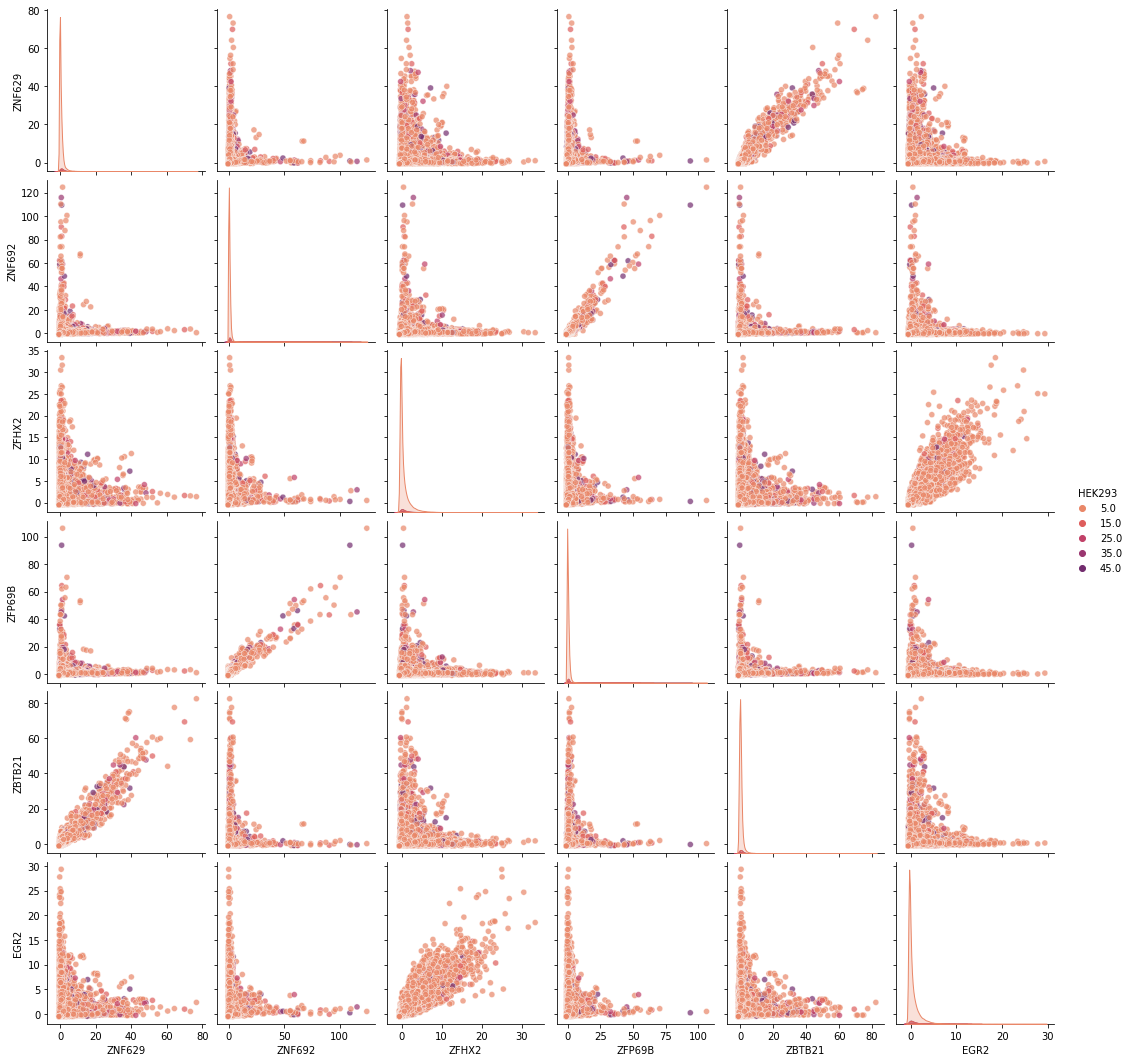

Most correlated features from enhancers epigenomes


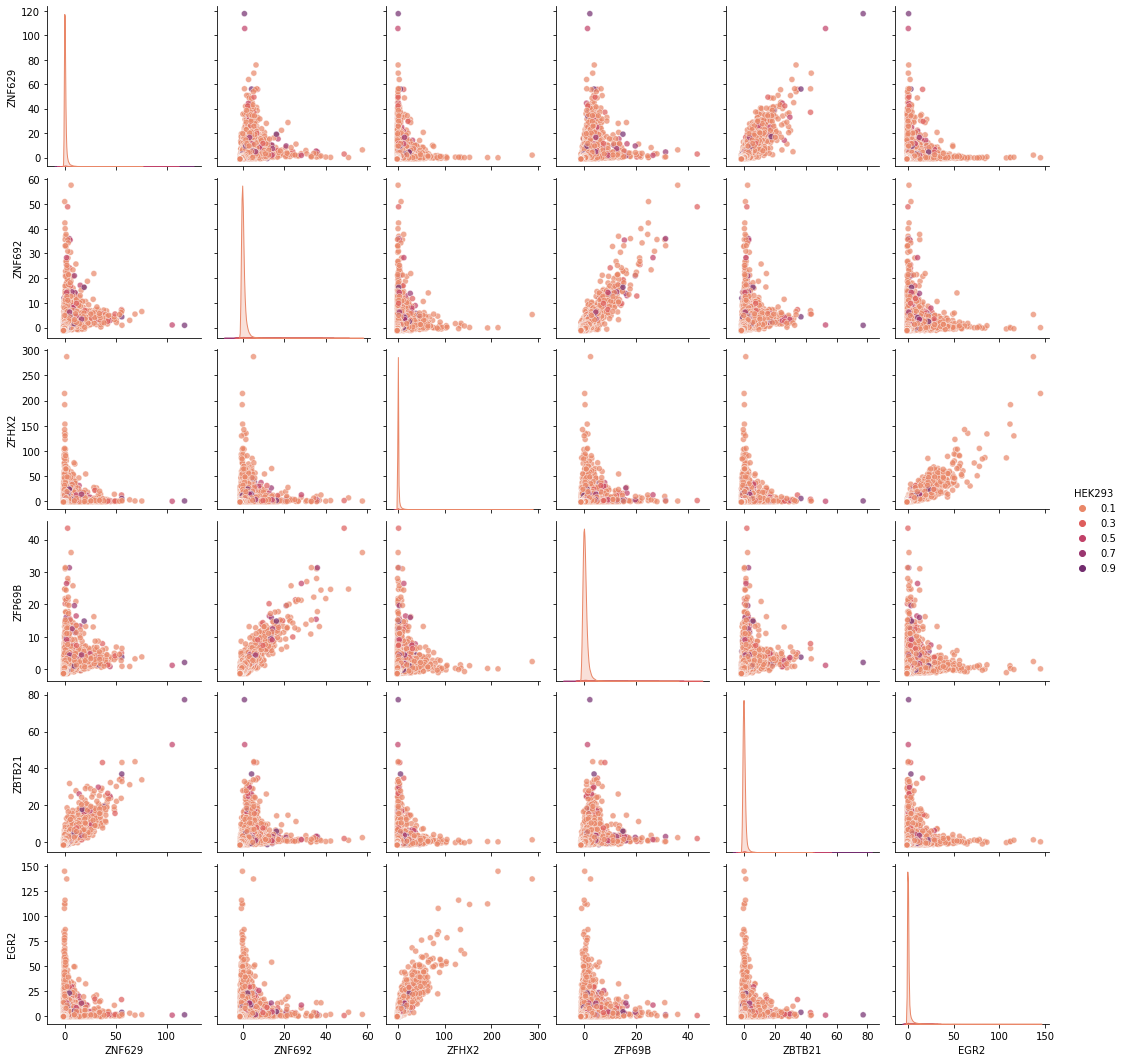

In [ ]:
# Sort scores
scores = {
    region:sorted(score, key=lambda x: np.abs(x[0]), reverse=True)
    for region, score in scores.items()
}

n_bins = 5
kbins_discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
# Plot most correlated features for each region
for region, x in epigenomes.items():
    _, firsts, seconds = list(zip(*scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")
    binarized_labels = pd.DataFrame(
        # Transform to make the labels the center of each bin
        np.round(kbins_discretizer.fit_transform(labels[region])/n_bins*labels[region].to_numpy().max()+labels[region].to_numpy().max()/(n_bins*2),2),
        index = labels[region].index)
    binarized_labels.columns = labels[region].columns
    sns.pairplot(pd.concat([
        x[columns],
        binarized_labels,
    ], axis=1), hue=binarized_labels.columns[0], palette=sns.color_palette("flare", np.unique(binarized_labels).size), plot_kws={'alpha':0.7}, diag_kind='kde')
    plt.show()

### Boruta

Boruta is a feature selection method that trains a random forest classifier (or regressor) and applies a feature importance metric to evaluate the importance of each feature. We should apply this method during the hold-out split in the final model evaluation function. However, since it is computationally expensive, Boruta is skipped in this work.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy
from multiprocessing import cpu_count

@Cache(
    cache_path=[
        "boruta/kept_features_{_hash}.json",
        "boruta/discarded_features_{_hash}.json"
    ],
    args_to_ignore=[
        "X_train", "y_train"
    ]
)
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    regression: bool,
    task_name: str,
    max_iter: int = 200
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    regression: bool,
        Whether the task is a binary classification one (False) or a regression one (True).
    task_name: str,
        The name of the task.
    max_iter: int = 200,
        Number of iterations to run Boruta for.
    """
    # According to the requested task we build either a random forest regressor
    # or a random forest classifier.
    if regression:
        model = RandomForestRegressor(n_jobs=cpu_count(), max_depth=5)
    else:
        model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        model,
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=1,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    # Filter out the unused featured.
    return kept_features, discarded_features

### Features distributions

Since we cannot show all distributions we select the top 10 most different features, using the pairwise euclidean distance between the features.

To represent distributions we use histograms on a log scale. Labels are discretized to show the different labels distributions.

Top 5 different features from promoters.


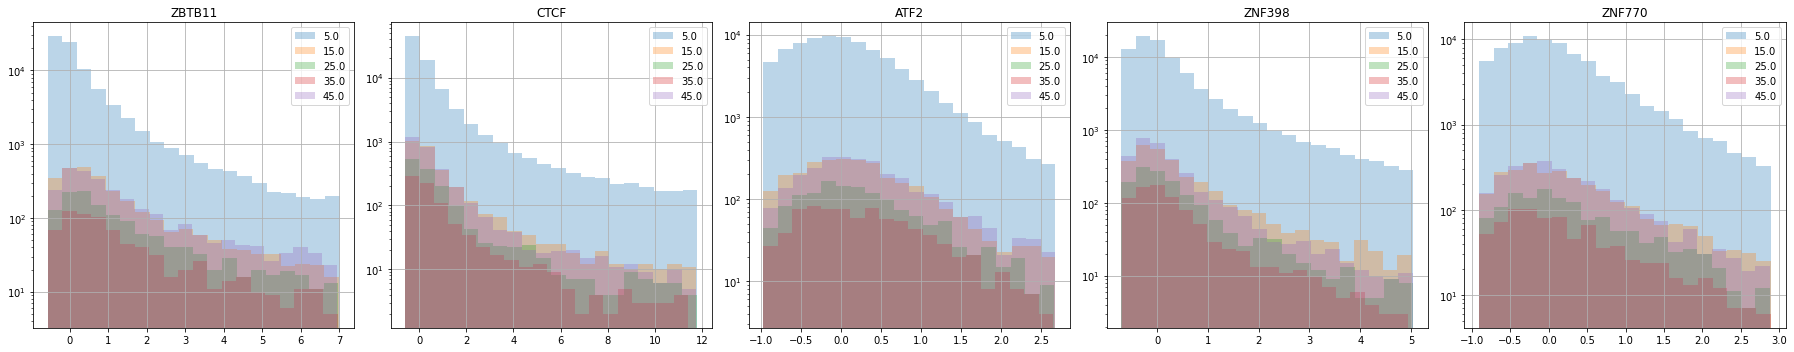

Top 5 different features from enhancers.


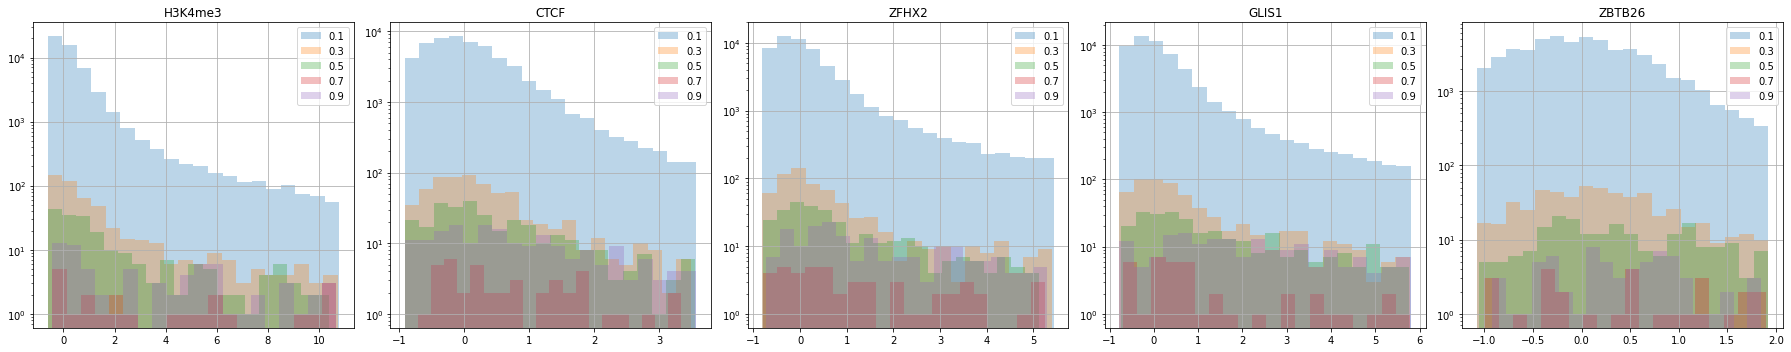

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def get_top_most_different(dist, n:int):
    return np.argsort(-np.mean(dist, axis=1).flatten())[:n]

top_number = 5

n_bins = 5
kbins_discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
for region, x in epigenomes.items():
    dist = euclidean_distances(x.T)
    most_distance_columns_indices = get_top_most_different(dist, top_number)
    columns = x.columns[most_distance_columns_indices]
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))
    print(f"Top {top_number} different features from {region}.")
    for column, axis in zip(columns, axes.flatten()):
        head, tail = x[column].quantile([0.05, 0.95]).values.ravel()
        
        mask = ((x[column] < tail) & (x[column] > head)).values
        
        cleared_x = x[column][mask]

        binarized_labels = pd.DataFrame(
            # Transform to make the labels the center of each bin
            np.round(kbins_discretizer.fit_transform(labels[region])/n_bins*labels[region].to_numpy().max()+labels[region].to_numpy().max()/(n_bins*2),2),
            index = labels[region].index)
        binarized_labels.columns = labels[region].columns
        cleared_y = binarized_labels.values.ravel()[mask]
        
        for bin_value in np.unique(binarized_labels):
            cleared_x[cleared_y==bin_value].hist(ax=axis, bins=20, alpha = 0.3)
        axis.legend(np.unique(binarized_labels))
        axis.set_yscale('log')
        axis.set_title(column)

        #Kernel density estimation is too slow, so we are gonna skip it
        #axis = sns.kdeplot(x=cleared_x.to_numpy(), y=labels[region][mask]["HEK293"].to_numpy())
    fig.tight_layout()
    plt.show()

# Sequence data retrieval

In order to retrieve sequence data of promoters and enhancers regions, we will use the [ucsc_genomes_downloader](https://github.com/LucaCappelletti94/ucsc_genomes_downloader) python package.

In [ ]:
# Helper function to retrieve bed coordinates from epigenomic dataset

def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [ ]:
genome = Genome(assembly)

Loading chromosomes for genome hg38:   0%|          | 0/25 [00:00<?, ?it/s]

# Data visualization

### t-SNE

T-SNE is a method for dimensionality reduction, mainly used for 2D and 3D visualization of data.

Here we want to apply t-SNE both to epigenomic and sequence data, in order to see if any kind of pattern or cluster emerges from the decomposition.

In [ ]:
# Here we need to use the cached decomposition because computing
# TSNE decompositions can get very expensive computationally
# I provide the TSNE decomposition within the course repository.
#@Cache(
#    cache_path="decompositions/tsne/{data_type}_{region}_{cell_line}_{metric}.pkl.gz",
    # We do not want to include the X variable into the hash
#    args_to_ignore=["X"],
#)
def get_tsne_decomposition(
    X: pd.DataFrame,
    data_type: str,
    region: str,
    cell_line: str,
    metric: str,
)->pd.DataFrame:
    """Return the 2D TSNE decomposition of the given data."""
    # The import of the TSNECUDA is within the method and not
    # outside because it is hard to install the package
    TSNE()
    return pd.DataFrame(
        TSNE(
            # Better performance may be achieved with cosine distance,
            # but currently TSNECUDA does not support other metrics.
            # Expecially for the sequence data, cosine distances may be foundamental
            # to get a semantically significant decomposition.
            perplexity= 100,
            n_iter = 1000,
            metric=metric,
            verbose=True,
        ).fit_transform(X.values),
        index=X.index
    )

In [ ]:
def scatter_with_heatmap(
    decomposition: pd.DataFrame,
    scores: np.ndarray,
    figure: Figure,
    ax: Axes
):
    scatter = ax.scatter(
        *decomposition.values.T,
        c=scores,
        cmap=plt.cm.get_cmap('RdYlBu'),
        norm=LogNorm(),
        s=3
    )
    color_bar = figure.colorbar(scatter, ax=ax)

Computing TSNE decompositions:   0%|          | 0/1 [00:00<?, ?it/s]

Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Decomposition method:   0%|          | 0/1 [00:00<?, ?it/s]

Task:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


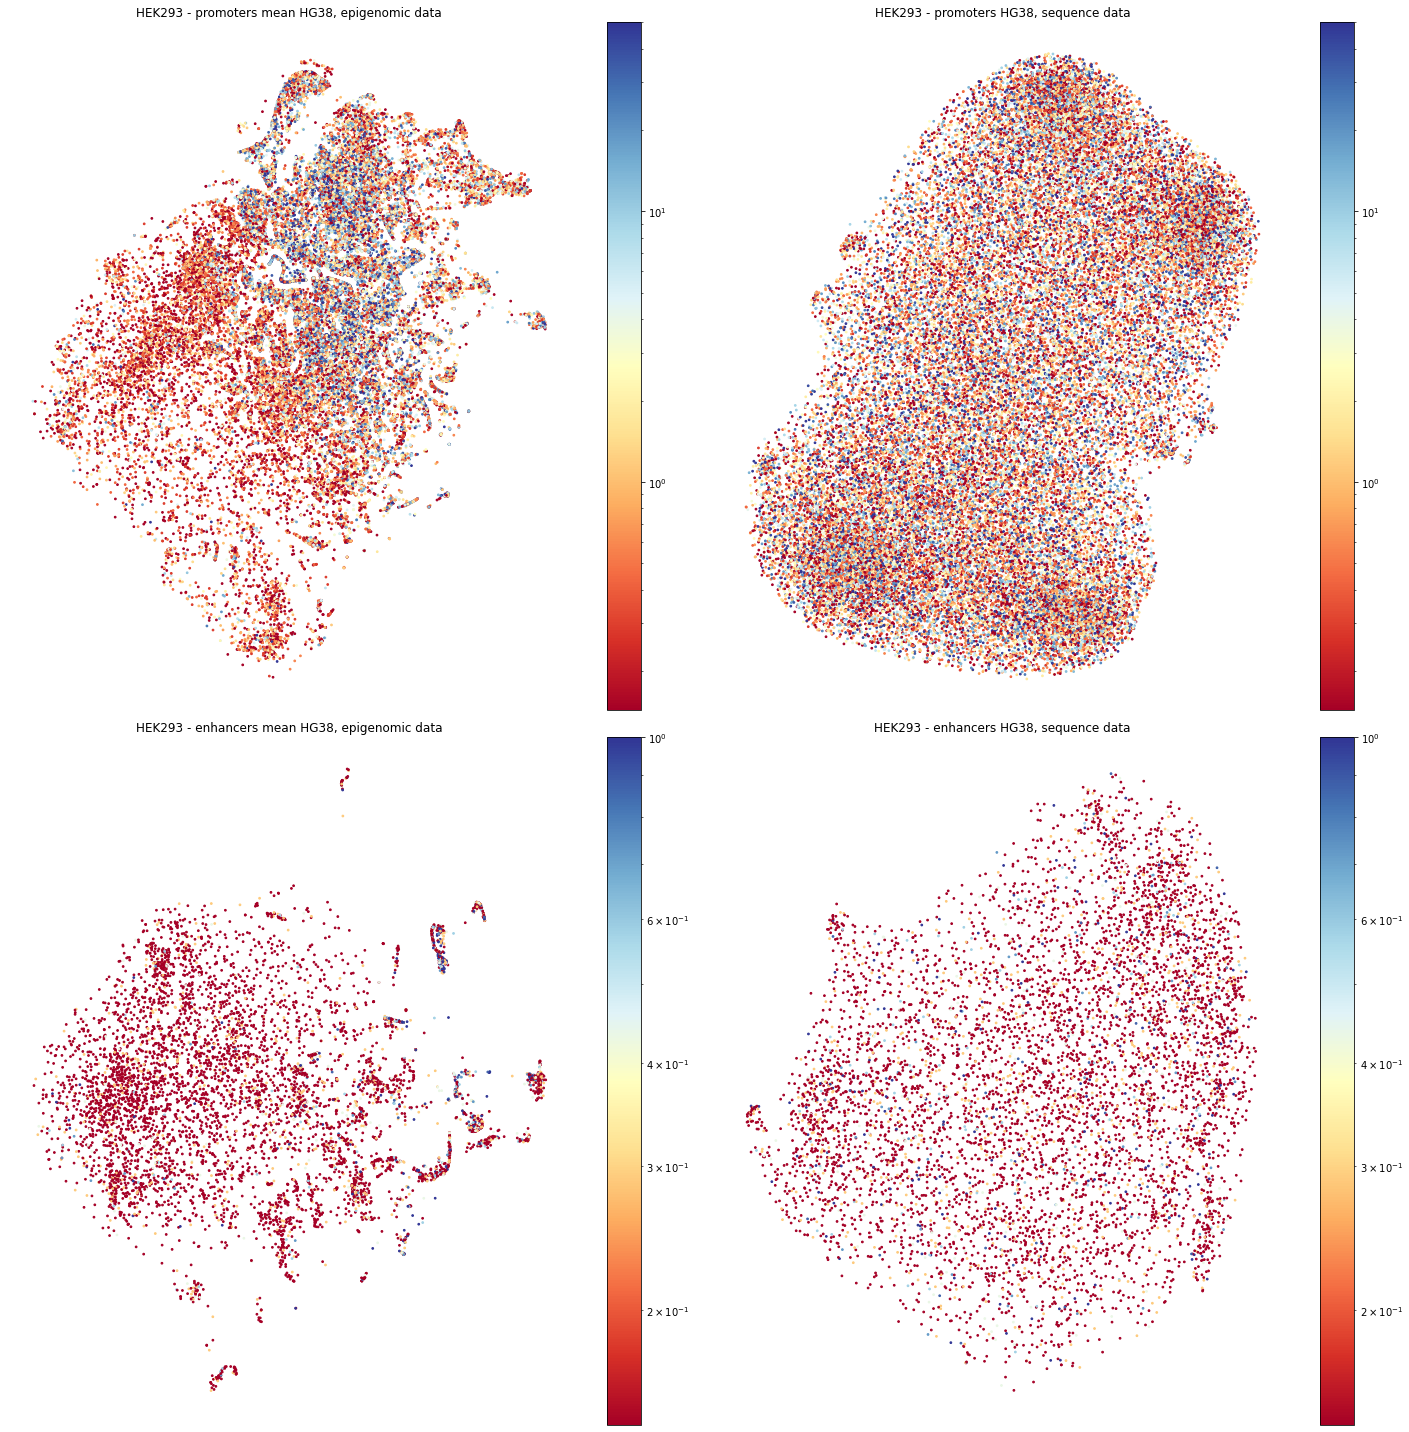

In [ ]:
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from keras_bed_sequence import BedSequence

fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(20, 20),
    squeeze=False
)

counter = 0
for i, cell_line in enumerate(tqdm([cell_line], desc="Computing TSNE decompositions")):
    for k, metric in enumerate(tqdm(["mean"], desc="Metrics", leave=True)):
        for l, decomposition_method in enumerate(tqdm([get_tsne_decomposition], desc="Decomposition method", leave=True)):
            for j, ((epigenomic, scores), region) in enumerate(tqdm((
                ((epigenomes["promoters"],labels["promoters"]),"promoters"),
                ((epigenomes["enhancers"],labels["enhancers"]),"enhancers"),
            ), desc="Task", leave=True)):
            
                decomposed_epigenomic = decomposition_method(
                    epigenomic,
                    "epigenomic",
                    region,
                    cell_line,
                    metric="innerproduct",
                )
                scatter_with_heatmap(
                    decomposition=decomposed_epigenomic,
                    scores=scores.values,
                    figure=fig,
                    ax=axes[counter][0]
                )
                axes[counter][0].set_title(f"{cell_line} - {region} {metric} HG38, epigenomic data")
                axes[counter][0].set_axis_off()

                sequence = pd.DataFrame(
                    np.array(BedSequence(
                        genome,
                        bed=to_bed(scores),
                        batch_size=1
                    )).reshape(-1, 4*256),
                    index=scores.index
                )
                decomposed_sequence = decomposition_method(
                    sequence,
                    "sequence",
                    region,
                    cell_line,
                    metric="innerproduct",
                    # It would be better to use the COSINE distance,
                    # but it is too terribly slow to be feaseable
                    # with all the considered use cases.
                    # distance_metric="cosine"
                )
                scatter_with_heatmap(
                    decomposition=decomposed_sequence,
                    scores=scores.values,
                    figure=fig,
                    ax=axes[counter][1]
                )
                axes[counter][1].set_title(f"{cell_line} - {region} HG38, sequence data")
                axes[counter][1].set_axis_off()

                counter += 1

fig.tight_layout()
plt.show()

# Model building

In order to tackle the regression task, we build three different types of Neural Network:

1) Feed Forward Neural Network (FFNN) for epigenomic data;

2) Convolutional Neural Network (CNN) for sequence data;

3) Multi-modal Neural Network (MMNN) for both epigenomic and sequence data.

In [ ]:
#@markdown Build regression FFNN function

def build_regression_ffnn(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for regression.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(64)(input_epigenomic_data)
    hidden = PReLU()(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(rate=0.2)(hidden)

    for _ in range(2):
        hidden = Dense(32)(hidden)
        hidden = PReLU()(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dropout(rate=0.2)(hidden)

    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="relu")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="RegressionMLP"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="mse",
        metrics=["mse"],
        #run_eagerly=True
    )

    return ffnn, input_epigenomic_data, last_hidden_ffnn

In [ ]:
#@markdown Build regression CNN function

def build_regression_cnn(
    window_size: int
)->Tuple[Model, Layer, Layer]:
    """Returns Convolutional Neural Network model for regression.
    
    Parameters
    -----------------------
    window_size: int,
        Size of the input genomic window.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
    hidden = Conv1D(16, kernel_size=3)(input_sequence_data)
    hidden = PReLU()(hidden)
    hidden = AveragePooling1D(pool_size=2)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(rate=0.2)(hidden)

    hidden = Conv1D(32, kernel_size=3)(input_sequence_data)
    hidden = PReLU()(hidden)
    hidden = MaxPooling1D(pool_size=2)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(rate=0.2)(hidden)

    hidden = Conv1D(64, kernel_size=3)(input_sequence_data)
    hidden = PReLU()(hidden)
    hidden = AveragePooling1D(pool_size=2)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(rate=0.2)(hidden)
        
    hidden = GlobalMaxPooling1D()(hidden)

    hidden = Dense(16)(hidden)
    hidden = PReLU()(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(rate=0.2)(hidden)
    hidden = Dense(32)(hidden)
    hidden = PReLU()(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(rate=0.2)(hidden)

    last_hidden_cnn = hidden
    output_cnn = Dense(1, activation="relu")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="RegressionCNN"
    )

    cnn.compile(
        optimizer="nadam",
        loss="mse",
        metrics=["mse"],
        #run_eagerly=True
    )
    return cnn, input_sequence_data, last_hidden_cnn

In [ ]:
#@markdown Build regression MMNN function

def build_regression_mmnn(
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for regression.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )
        
    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_regression_ffnn(input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_regression_cnn(window_size)
        
    concatenation_layer = Concatenate()([
        last_hidden_ffnn,
        last_hidden_cnn
    ])

    hidden = concatenation_layer

    hidden = Dense(64)(hidden)
    hidden = PReLU()(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(rate=0.2)(hidden)
    hidden = Dense(32)(hidden)
    hidden = PReLU()(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(rate=0.2)(hidden)


    last_hidden_mmnn = hidden
    output_mmnn = Dense(1, activation="relu")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="RegressionMMNN" if input_shape is None else "RegressionCleanMMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="mse",
        metrics=["mse"],
        #run_eagerly=True
    )

    return mmnn

## Sequence building

Here we define some helper functions to retrieve and organize the data to be fed into neural networks.

In [ ]:
#@markdown FFNN, CNN, MMNN sequence builder functions

batch_size = 1024

def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = batch_size
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regression, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = batch_size
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regression, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = batch_size
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regression, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

In [ ]:
#@markdown Model training function



class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session()
        gc.collect()

#@Cache(
#    cache_path=[
#        "model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.xz",
#        "model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.xz",
#    ],
#    args_to_ignore=[
#        "model", "train_sequence", "val_sequence", "test_sequence"
#    ]
#)
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    train_sequence,
    val_sequence,
    test_sequence,
    window_size: int,
    holdout_number: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    window_size: int,
        The window size considered.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """


    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=val_sequence,
        epochs=1000,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "val_loss",
                patience=20,
                restore_best_weights=True,
            ),
            ClearMemory(),
            # I have commented this because we do not need this loading bar
            # when running the main experiment loop. When you experiment with
            # the model structure you may want to enable this to get a feel
            # of how the model is performing during the training.
            #TqdmCallback(verbose=1)
        ],
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    val_evaluation = dict(zip(model.metrics_names, model.evaluate(val_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    val_evaluation["run_type"] = "val"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, val_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["window_size"] = window_size
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        val_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

# Model evaluation

We prepare an helper function to generate holdouts.

In [ ]:
# Here for speed sake we are only doing two holdouts
# but normally at least 10 are executed
number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

regression_holdouts_generator = ShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

NB: In the following function we skip feature selection step since it takes too long to be executed.

In [ ]:
# Create a list to store all the computed performance
all_regression_performance = []
cell_line = "HEK293"
assembly = "hg38"

for window_size in tqdm([64,256], desc="Window sizes"):
    # For each task
    for task in tqdm((
        active_enhancers_vs_inactive_enhancers,
        active_promoters_vs_inactive_promoters
    ), desc="Tasks"):
        task_name = task.__name__

        # Retrieve epigenomic data
        X, y = task(
            cell_line = cell_line,
            assembly = assembly,
            dataset = "fantom",
            metric = "mean",
            window_size = window_size,
            root = "datasets",
        )

        # Labels clipping
        if task_name == "active_promoters_vs_inactive_promoters":
            y[y>50] = 50
        if task_name == "active_enhancers_vs_inactive_enhancers":
            y[y>1] = 1

        # Extract the bed coordinates from the epigenomic dataset
        bed = to_bed(X)
        # Get the number of features of this specific dataset
        number_of_features = X.shape[1]
        # Start the main loop, iterating through the holdouts
        for holdout_number, (train_indices, test_indices) in tqdm(
            enumerate(regression_holdouts_generator.split(X, y)),
            total=number_of_splits,
            leave=True,
            desc="Computing holdouts"
        ):
            # Get the training and test data
            train_X, val_X, train_bed, val_bed, train_y, val_y = train_test_split(
                X.iloc[train_indices],
                bed.iloc[train_indices],
                y.iloc[train_indices],
                train_size=0.8
            )

            test_bed = bed.iloc[test_indices]
            test_X = X.iloc[test_indices]
            test_y = y.iloc[test_indices]
            
            # Impute and normalize the epigenomic data
            train_X = robust_zscoring(knn_imputation(train_X)).to_numpy()
            val_X = robust_zscoring(knn_imputation(val_X)).to_numpy()
            test_X = robust_zscoring(knn_imputation(test_X)).to_numpy()

            # Feature selection
            # We skip feature selection step since it takes too much time.
            #kept_features, discarded_features = execute_boruta_feature_selection(
            #    train_X,
            #    train_y,
            #    holdout_number,
            #    True,
            #    task_name,
            #)
            #train_X = train_X[kept_features]
            #val_X = val_X[kept_features]
            #test_X = test_X[kept_features]

            # Flatten the output values
            train_y = train_y.values.flatten()
            val_y = val_y.values.flatten()
            test_y = test_y.values.flatten()
            
            ffnn, input_epigenomic_data, last_hidden_ffnn = build_regression_ffnn(number_of_features)
            cnn, input_sequence_data, last_hidden_cnn = build_regression_cnn(window_size)
            mmnn = build_regression_mmnn(
                input_sequence_data=input_sequence_data,
                input_epigenomic_data=input_epigenomic_data,
                last_hidden_ffnn=last_hidden_ffnn,
                last_hidden_cnn=last_hidden_cnn
            )
            for model, train_sequence, val_sequence, test_sequence in tqdm(
                (
                    (ffnn,
                    get_ffnn_sequence(train_X, train_y),
                    get_ffnn_sequence(val_X, val_y),
                    get_ffnn_sequence(test_X, test_y)),
                    (cnn,
                    get_cnn_sequence(genome, train_bed, train_y),
                    get_cnn_sequence(genome, val_bed, val_y),
                    get_cnn_sequence(genome, test_bed, test_y)),
                    (mmnn,
                    get_mmnn_sequence(genome, train_bed, train_X, train_y),
                    get_mmnn_sequence(genome, val_bed, val_X, val_y),
                    get_mmnn_sequence(genome, test_bed, test_X, test_y)),
                ),
                desc="Training models",
                leave=True
            ):
            
                # We compute the model performance
                history, performance = train_model(
                    model,
                    model.name,
                    task_name,
                    cell_line,
                    train_sequence,
                    val_sequence,
                    test_sequence,
                    window_size,
                    holdout_number
                )

                del history
                del train_sequence, val_sequence, test_sequence
                tf.keras.backend.clear_session()
                gc.collect()

                #plt.plot(history)
                #plt.show()

                # We chain the computed performance to the performance list
                all_regression_performance.append(performance)

            del train_X, val_X, test_X
            del train_bed, val_bed, test_bed
            del train_y, val_y, test_y
            del ffnn, input_epigenomic_data, last_hidden_ffnn
            del cnn, input_sequence_data, last_hidden_cnn
            del mmnn
            del holdout_number, train_indices, test_indices
            tf.keras.backend.clear_session()
            gc.collect()
        
        del task_name
        del X, y
        del bed
        del number_of_features
        tf.keras.backend.clear_session()
        gc.collect()
        
# We convert the computed performance list into a DataFrame
all_regression_performance = pd.concat(all_regression_performance)

Window sizes:   0%|          | 0/2 [00:00<?, ?it/s]

Tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

Training models:   0%|          | 0/3 [00:00<?, ?it/s]

# Results

In [ ]:
%load_ext google.colab.data_table
all_regression_performance = all_regression_performance.drop(columns=["loss","holdout_number"])
all_regression_performance["window_size"] = [str(w) for w in all_regression_performance["window_size"]]
all_regression_performance

,mse,run_type,model_name,task,window_size
0,0.008867,train,RegressionMLP,active_enhancers_vs_inactive_enhancers,64
1,0.008591,val,RegressionMLP,active_enhancers_vs_inactive_enhancers,64
2,0.008210,test,RegressionMLP,active_enhancers_vs_inactive_enhancers,64
0,0.008867,train,RegressionCNN,active_enhancers_vs_inactive_enhancers,64
1,0.008591,val,RegressionCNN,active_enhancers_vs_inactive_enhancers,64
...,...,...,...,...,...
1,98.256378,val,RegressionCNN,active_promoters_vs_inactive_promoters,256
2,100.830139,test,RegressionCNN,active_promoters_vs_inactive_promoters,256
0,62.232140,train,RegressionMMNN,active_promoters_vs_inactive_promoters,256
1,75.651176,val,RegressionMMNN,active_promoters_vs_inactive_promoters,256


Rendering barplots:   0%|          | 0/1 [00:00<?, ?it/s]

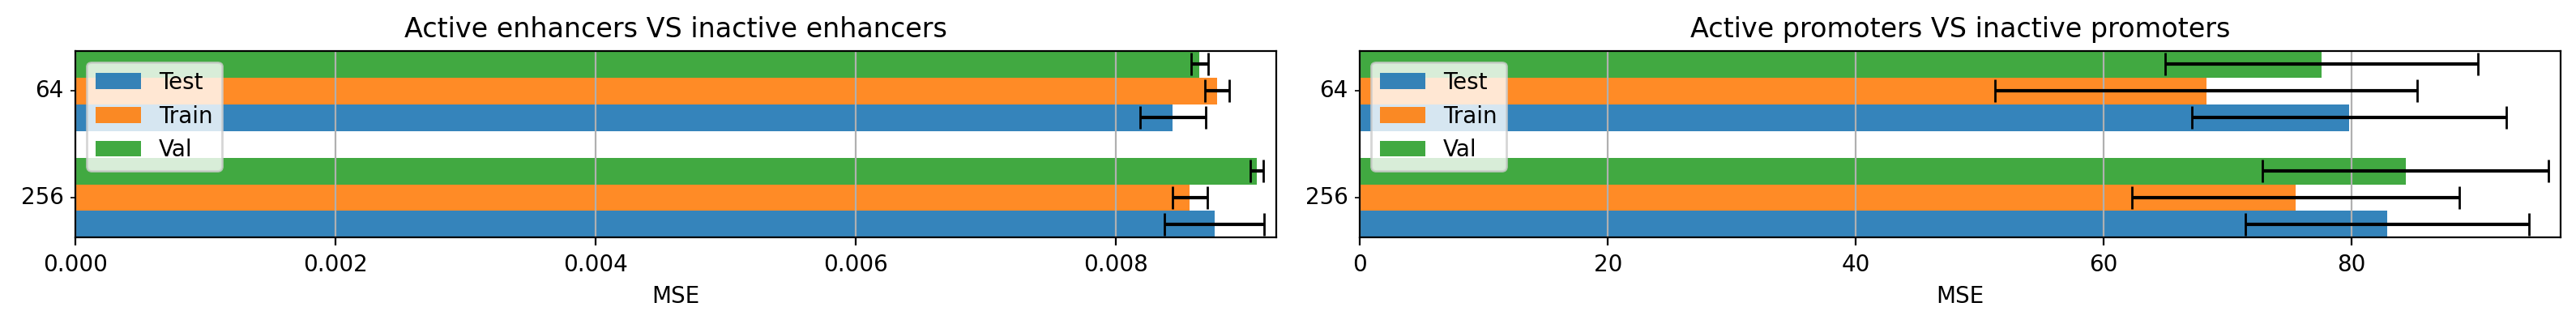

Rendering barplots:   0%|          | 0/1 [00:00<?, ?it/s]

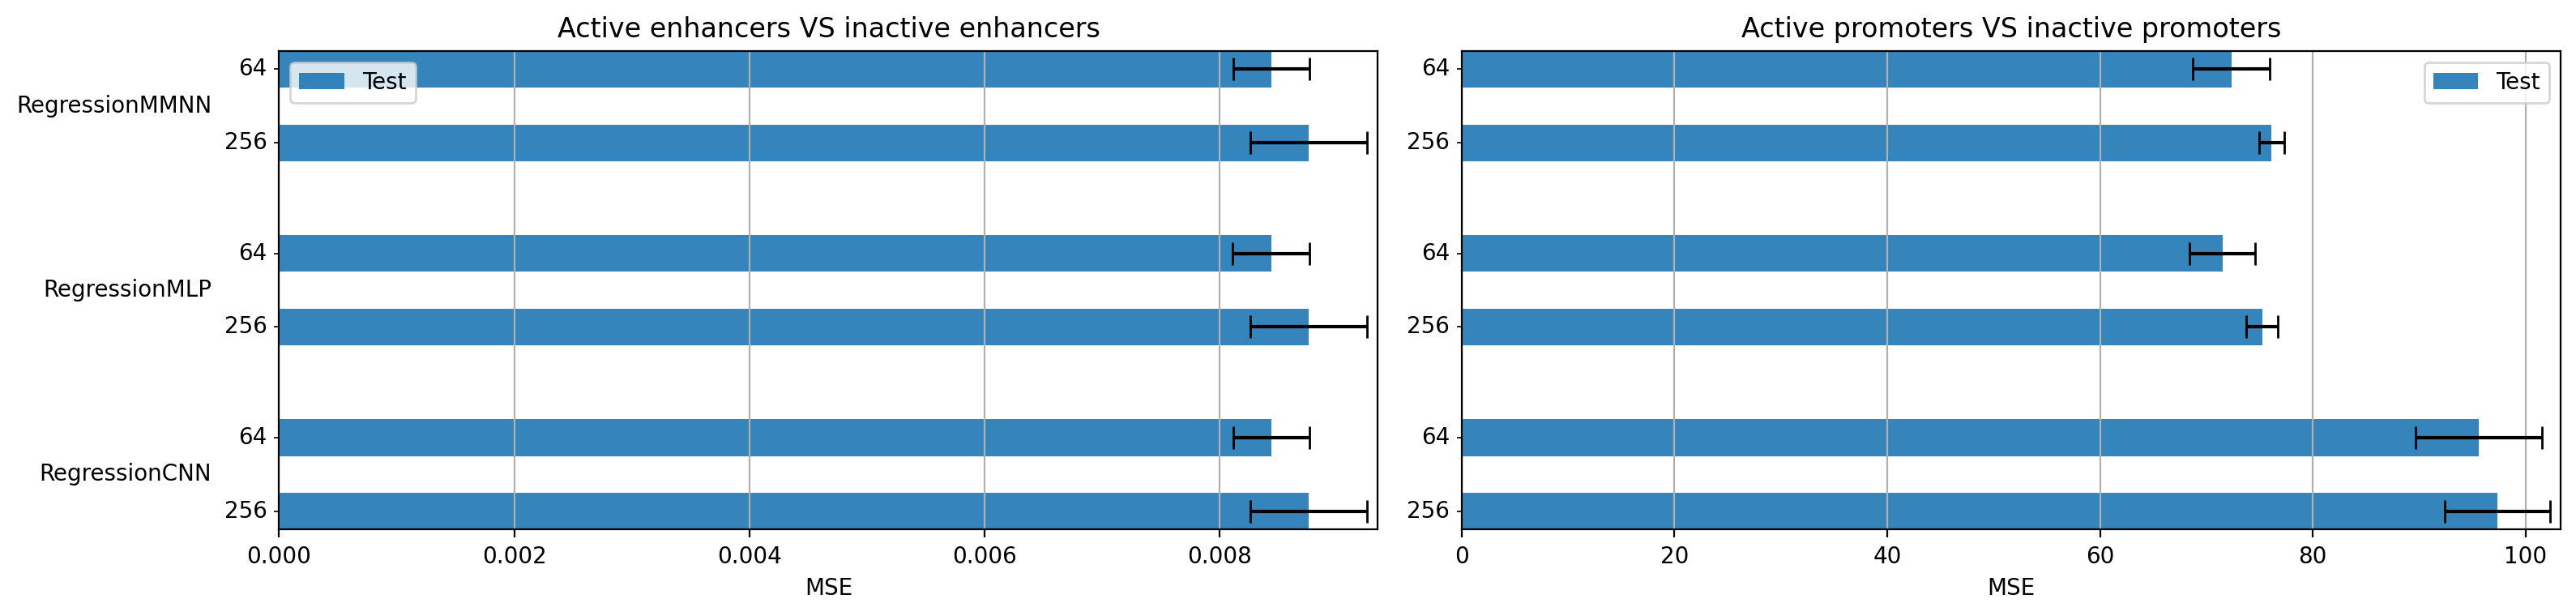

Rendering barplots:   0%|          | 0/1 [00:00<?, ?it/s]

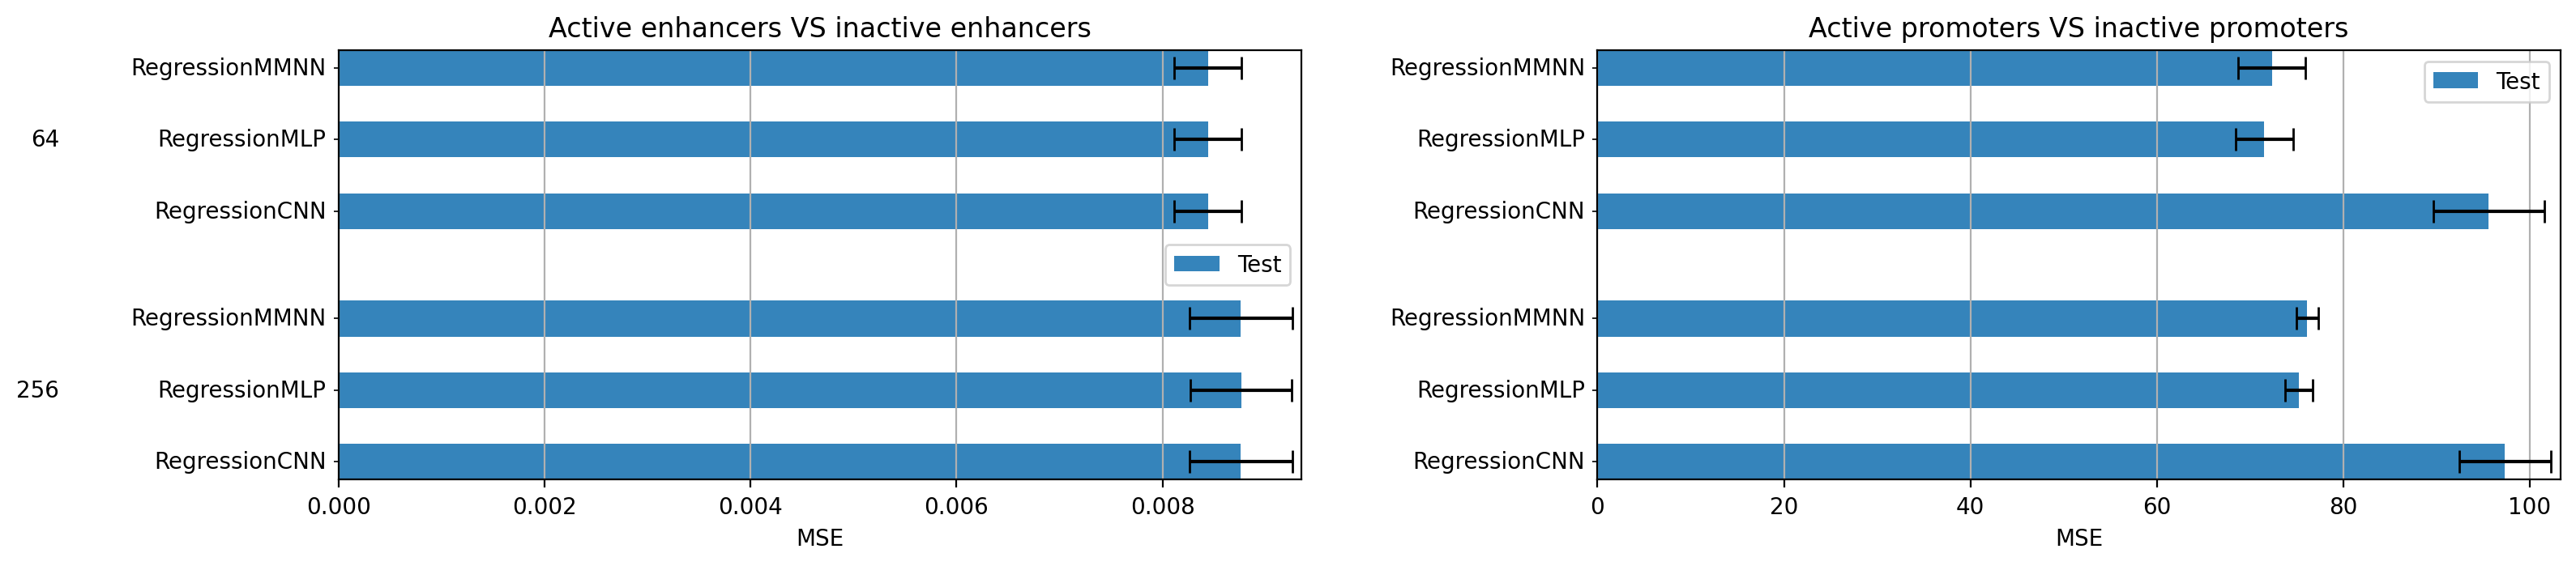

In [ ]:
barplots(
    all_regression_performance,
    groupby=["task","window_size","run_type"],
    orientation="horizontal",
    height=8,
    subplots=True,
    use_multiprocessing=False,
)
plt.show()

barplots(
    all_regression_performance[all_regression_performance["run_type"]=="test"],
    groupby=["task","model_name","window_size","run_type"],
    orientation="horizontal",
    height=8,
    subplots=True,
    use_multiprocessing=False,
)
plt.show()

barplots(
    all_regression_performance[all_regression_performance["run_type"]=="test"],
    groupby=["task","window_size","model_name","run_type"],
    orientation="horizontal",
    height=8,
    subplots=True,
    use_multiprocessing=False,
)
plt.show()

We perform Wilcoxon test to verify if there exists statistical differences in performance of the models and window sizes considered for the two tasks studied.

In [ ]:
for task in all_regression_performance.task.unique():
    if task == 'active_enhancers_vs_inactive_enhancers':
        print("Task: [Active enhancers VS inactive enhancers]\n")
    if task == 'active_promoters_vs_inactive_promoters':
        print("Task: [Active promoters VS inactive promoters]\n")
    for outer_model in all_regression_performance.model_name.unique():
        outer_model_performance = all_regression_performance[
            (all_regression_performance.model_name == outer_model) &
            (all_regression_performance.task == task) &
            (all_regression_performance.run_type == "test")
        ]
        for model in all_regression_performance.model_name.unique():
            if outer_model >= model:
                continue
            model_performance = all_regression_performance[
                (all_regression_performance.model_name == model) &
                (all_regression_performance.task == task) &
                (all_regression_performance.run_type == "test")
            ]

            for metric in ["mse"]:
                outer, inner = outer_model_performance[metric], model_performance[metric]
                _, p_value = wilcoxon(outer, inner)
                if p_value < 0.05:
                    if outer.mean() < inner.mean():
                        best_model, worse_model = outer_model, model
                    else:
                        best_model, worse_model = model, outer_model
                    print("+ [Model] {} outperforms {} with p-value {} on metric {}.".format(
                        best_model,
                        worse_model,
                        p_value,
                        metric
                    ))
                else:
                    print("- [Model] {} is statistically indistinguishable from {} with p-value {} on metric {}.".format(
                        outer_model,
                        model,
                        p_value,
                        metric
                    ))
    print("")
    for outer_window in all_regression_performance.window_size.unique():
        outer_window_performance = all_regression_performance[
            (all_regression_performance.window_size == outer_window) &
            (all_regression_performance.task == task) &
            (all_regression_performance.run_type == "test")
        ]
        for window in all_regression_performance.window_size.unique():
            if outer_window >= window:
                continue
            window_performance = all_regression_performance[
                (all_regression_performance.window_size == window) &
                (all_regression_performance.task == task) &
                (all_regression_performance.run_type == "test")
            ]

            for metric in ["mse"]:
                outer, inner = outer_window_performance[metric], window_performance[metric]
                _, p_value = wilcoxon(outer, inner)
                if p_value < 0.05:
                    if outer.mean() < inner.mean():
                        best_window, worse_window = outer_window, window
                    else:
                        best_window, worse_window = window, outer_window
                    print("+ [Window size] {}bp outperforms {}bp with p-value {} on metric {}.".format(
                        best_window,
                        worse_window,
                        p_value,
                        metric
                    ))
                else:
                    print("- [Window size] {}bp is statistically indistinguishable from {}bp with p-value {} on metric {}.".format(
                        outer_window,
                        window,
                        p_value,
                        metric
                    ))
    print("\n\n")

Task: [Active enhancers VS inactive enhancers]

- [Model] RegressionMLP is statistically indistinguishable from RegressionMMNN with p-value 0.4652088184521418 on metric mse.
- [Model] RegressionCNN is statistically indistinguishable from RegressionMLP with p-value 0.4652088184521418 on metric mse.
- [Model] RegressionCNN is statistically indistinguishable from RegressionMMNN with p-value 0.31731050786291415 on metric mse.

+ [Window size] 64bp outperforms 256bp with p-value 0.027281171477617997 on metric mse.



Task: [Active promoters VS inactive promoters]

- [Model] RegressionMLP is statistically indistinguishable from RegressionMMNN with p-value 0.06788915486182899 on metric mse.
- [Model] RegressionCNN is statistically indistinguishable from RegressionMLP with p-value 0.06788915486182899 on metric mse.
- [Model] RegressionCNN is statistically indistinguishable from RegressionMMNN with p-value 0.06788915486182899 on metric mse.

- [Window size] 256bp is statistically indistinguisha

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
